## Most of this code has been copied from a DeepLearningAI course that can be found here:  https://www.deeplearning.ai/courses/generative-adversarial-networks-gans-specialization/

In [1]:
#neural network libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torchvision.utils import make_grid

#Common libraries
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np 

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(device)

cuda


In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

## Generator Block to be used in more advance architexture.

In [3]:
class GenBlock(nn.Module):
    def __init__(self, in_channels: int = 10, out_channels: int = 64, img_channels: int = 1):
        super(GenBlock, self).__init__()

        self.act = nn.ReLU(inplace= True) 
        self.in_channels = in_channels

        self.modules_dict = nn.ModuleDict()
        self.modules_dict["Block_0"] = self.block(in_channels, out_channels * 4)
        self.modules_dict["Block_1"] = self.block(out_channels*4, out_channels*2, kernel_size = 4, stride = 1)
        self.modules_dict["Block_2"] = self.block(out_channels*2, out_channels)
        self.modules_dict["Block_3"] = self.block(out_channels, img_channels, kernel_size=4, final_layer=True)

    def block(self, ic: int, oc: int,
            kernel_size: int = 3, 
            stride: int = 2, 
            dropout: float = 0.4, 
            final_layer = False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Args:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        
        Return:
            block(nn.Sequential()): return a sequence of operations corresponding to a generator block of DCGAN;
        '''
        if not final_layer:
        
            block = nn.Sequential(
                    nn.ConvTranspose2d(ic, oc, kernel_size, stride),
                    nn.BatchNorm2d(oc),
                    nn.Dropout(dropout),
                    self.act
                    )
        
        else: 
            block = nn.Sequential(
                    nn.ConvTranspose2d(ic, oc, kernel_size, stride),
                    nn.Tanh()
                    )
        
        return block
    

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.in_channels, 1, 1)
        
        for key, modules in self.modules_dict.items():

            x = modules(x)
        return x

## A simple Discriminator for MNIST DATASET

In [4]:
class Discriminator(nn.Module):

    def __init__(self, output_channels: int = 64, img_channels: int = 1):
        super(Discriminator, self).__init__()

        self.modules_dict = nn.ModuleDict()
        self.modules_dict["Block_0"] = self.block(img_channels, output_channels)
        self.modules_dict["Block_1"] = self.block(output_channels, output_channels*2)
        self.modules_dict["Block_2"] = self.block(output_channels*2, 1, final_layer = True)

    def block(self, 
            input_channels: int, 
            output_channels: int, 
            kernel_size: int = 4, 
            stride: int = 2, 
            final_layer: bool = False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Args:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        Return:
            block(nn.Sequential()): return a sequence of operations corresponding to a generator block of DCGAN;
        '''
        if not final_layer:
            block =  nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            block =  nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        
        return block

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        for key, modules in self.modules_dict.items():

            image = modules(image)
            
        return image.view(len(image), -1)

## Noise

In [5]:
def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

In [6]:
import torch.nn.functional as F
def get_one_hot_labels(labels: torch.tensor, n_classes: int):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return torch.nn.functional.one_hot(labels, n_classes)


In [7]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        This is the One Hot Class vector.
    '''
    combined = torch.cat((x.float(),y.float()),dim = 1)
    return combined

## Import datas and preprocessing.

In [8]:
img_shape = (1, 28, 28)
n_classes = 10

criterion = nn.BCEWithLogitsLoss()
z_dim = 100
batch_size = 128
lr = 0.0002

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [9]:
generator_input_dim = z_dim + n_classes
discriminator_im_chan = img_shape[0] + n_classes

### Initialise the discriminator and the generator with the Xavier init method.
The weights_init function is used to initialize the weights of the models 
using the Xavier initialization method, 
which helps prevent the vanishing or exploding gradient problem during training. 
The apply method is then used to apply the initialization function 
to all the layers of the generator and discriminator models.

In [10]:
gen = GenBlock(in_channels = generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(img_channels = discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## Training function

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 3.15843968474865, discriminator loss: 0.17320437581185252


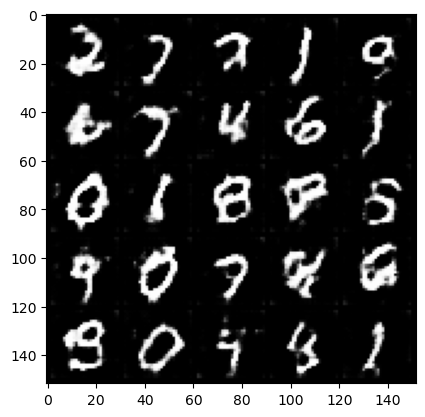

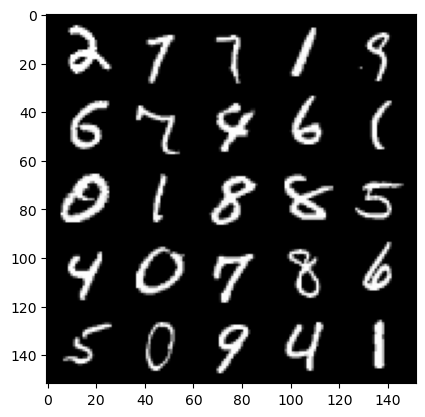

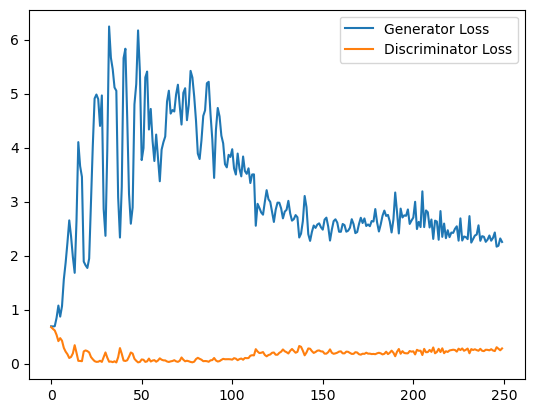

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 1.9398878015995025, discriminator loss: 0.3338059772968292


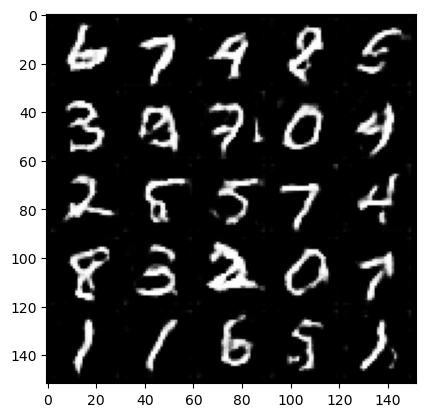

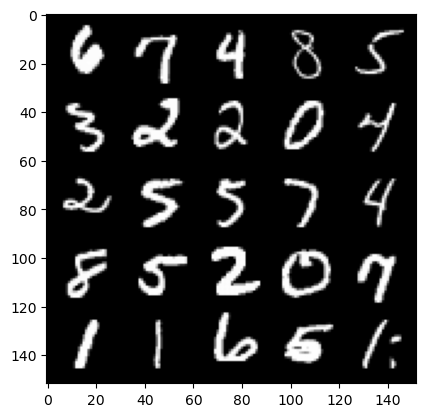

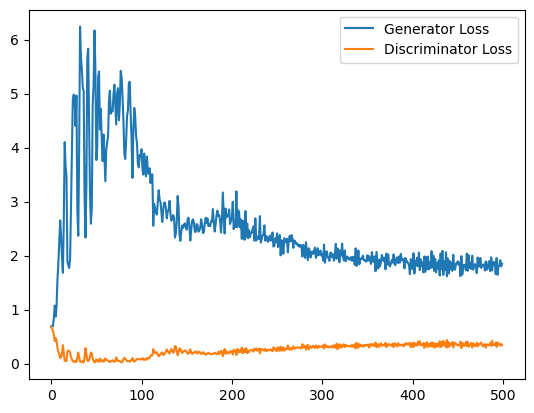

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 1.79936418299675, discriminator loss: 0.36237381758093834


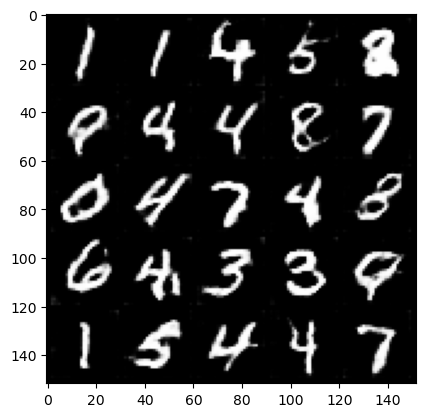

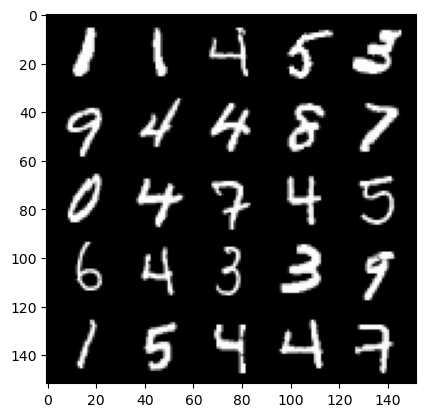

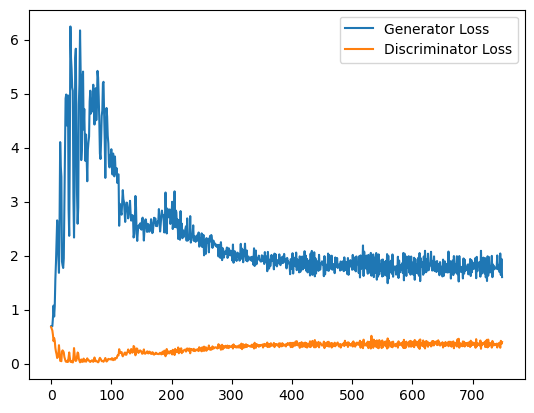

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 1.8172894721150399, discriminator loss: 0.35527093692719935


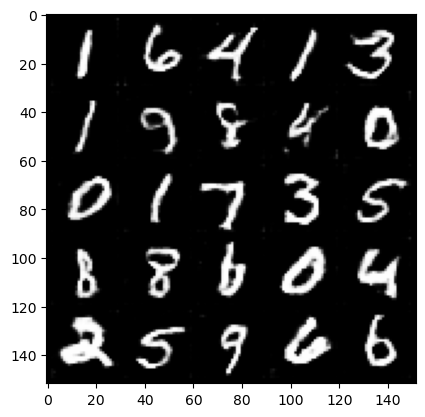

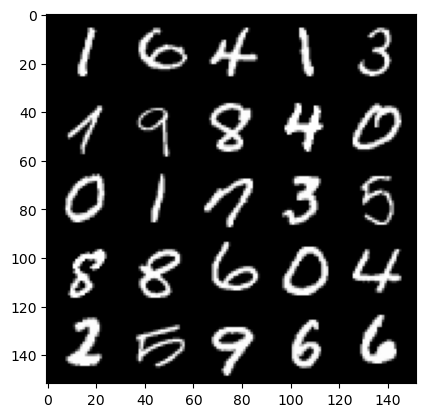

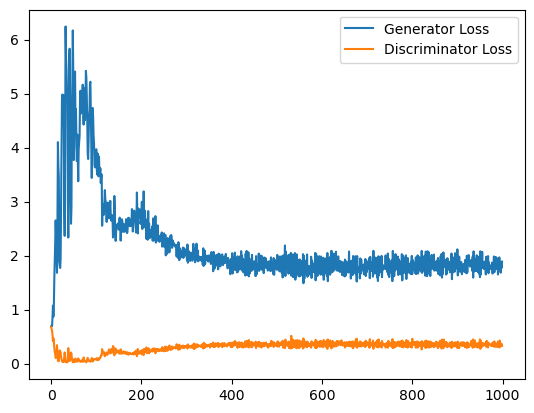

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [11]:
n_epochs = 50
display_step = 5000
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, img_shape[1], img_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        
        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 1, 28, 28)


        fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        
        # Make sure shapes are correct 
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)
        
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1